In [2]:
import json
import seaborn 
from math import ceil 
import numpy as np 
import pandas as pd
from pathlib import Path 
import plot_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from tqdm import tqdm

import plot_utils
from importlib import reload
reload(plot_utils)

plot_utils.set_style()

## Functions 

In [3]:
def read_ini(filename): 
    with open(filename, 'r') as f: 
        lines = f.read().splitlines() 
    
    params = {}
    for line in lines: 
        p, val = line.split(': ')
        try: 
            val = float(val)
        except: 
            pass 
        params[p] = val
    return params

def read_summary(filename): 
    with open(filename, 'r') as f: 
        summary = json.load(f)
    return summary 

def calc_actual_sm_cost(route_file: Path): 
    with open(route_file, 'r') as f: 
        routes = json.load(f)
    
    starting_materials = {}
    for entry in routes.values(): 
        for rxn in entry['Reactions']:
            if rxn['smiles'].startswith('>>'):
                sm = rxn['smiles'].split('>>')[1]
                starting_materials[sm] = rxn["starting material cost ($/g)"]

    return sum(starting_materials.values())

def get_info(folder: Path):
    sfile = folder / 'solution' / 'summary.json'
    rfile = folder / 'solution' / 'routes.json'
    pfile = folder / 'params.ini'
    if not sfile.exists() or not pfile.exists(): 
        print(f'Either summary or param file does not exist in {folder}, returning None')
        return None 
    
    summary = read_summary(sfile)
    params = read_ini(pfile)
    sm_cost = {'Starting Material Cost (Actual)': calc_actual_sm_cost(rfile)}

    return {**summary, **params, **sm_cost}


# Settings

In [66]:
case = 'garib'

# Create df with all information 

In [4]:
folder = f'../results/{case}_grid_nonlinear'

data = []
for subf in Path(folder).glob('*'):
    dat = get_info(subf)
    if dat is not None: 
        data.append(dat)

df = pd.DataFrame(data) # .sort_values(by='starting_material_budget', ascending=True)
convert_dict = {'starting_material_budget': int,
                'max_rxns': int
                }
  
df = df.astype(convert_dict)
# df_filtered = df.loc[df['starting_material_budget']<=130]

# df['starting_material_budget'] = df['starting_material_budget'].astype('category')


In [61]:
df.head()

,Number targets,Fraction targets selected,Cumulative reward of selected compounds,Possible reward,Number starting materials (some may be unused),Cost starting materials (some may be unused),Number reaction steps (some may be unused),Average reaction score (some may be unused),Run time,Number of variables,...,solver,start_cost_weight,starting_material_budget,target_csv,time_limit,time_per_target,tree_host,tree_lookup_dir,variable_costs,Starting Material Cost (Actual)
0,64,0.528926,44.000000,90.769231,51,109.9,78,0.860651,539.822097,29672,...,pulp,1.0,110,examples/amd/targets.csv,12.0,30.0,None,None,False,109.9
1,9,0.074380,6.384615,90.769231,8,151.8,2,0.988547,0.790101,29672,...,pulp,1.0,210,examples/amd/targets.csv,12.0,30.0,None,None,False,151.8
2,34,0.280992,22.307692,90.769231,25,49.5,25,0.984308,33.510288,29672,...,pulp,1.0,50,examples/amd/targets.csv,12.0,30.0,None,None,False,49.5
3,54,0.446281,35.230769,90.769231,45,207.4,45,0.913292,228.521535,29672,...,pulp,1.0,210,examples/amd/targets.csv,12.0,30.0,None,None,False,207.4
4,37,0.305785,22.923077,90.769231,29,73.6,21,0.981953,46.822067,29672,...,pulp,1.0,90,examples/amd/targets.csv,12.0,30.0,None,None,False,73.6


# Varying reaction and starting material budgets

NameError: name 'df_filtered' is not defined

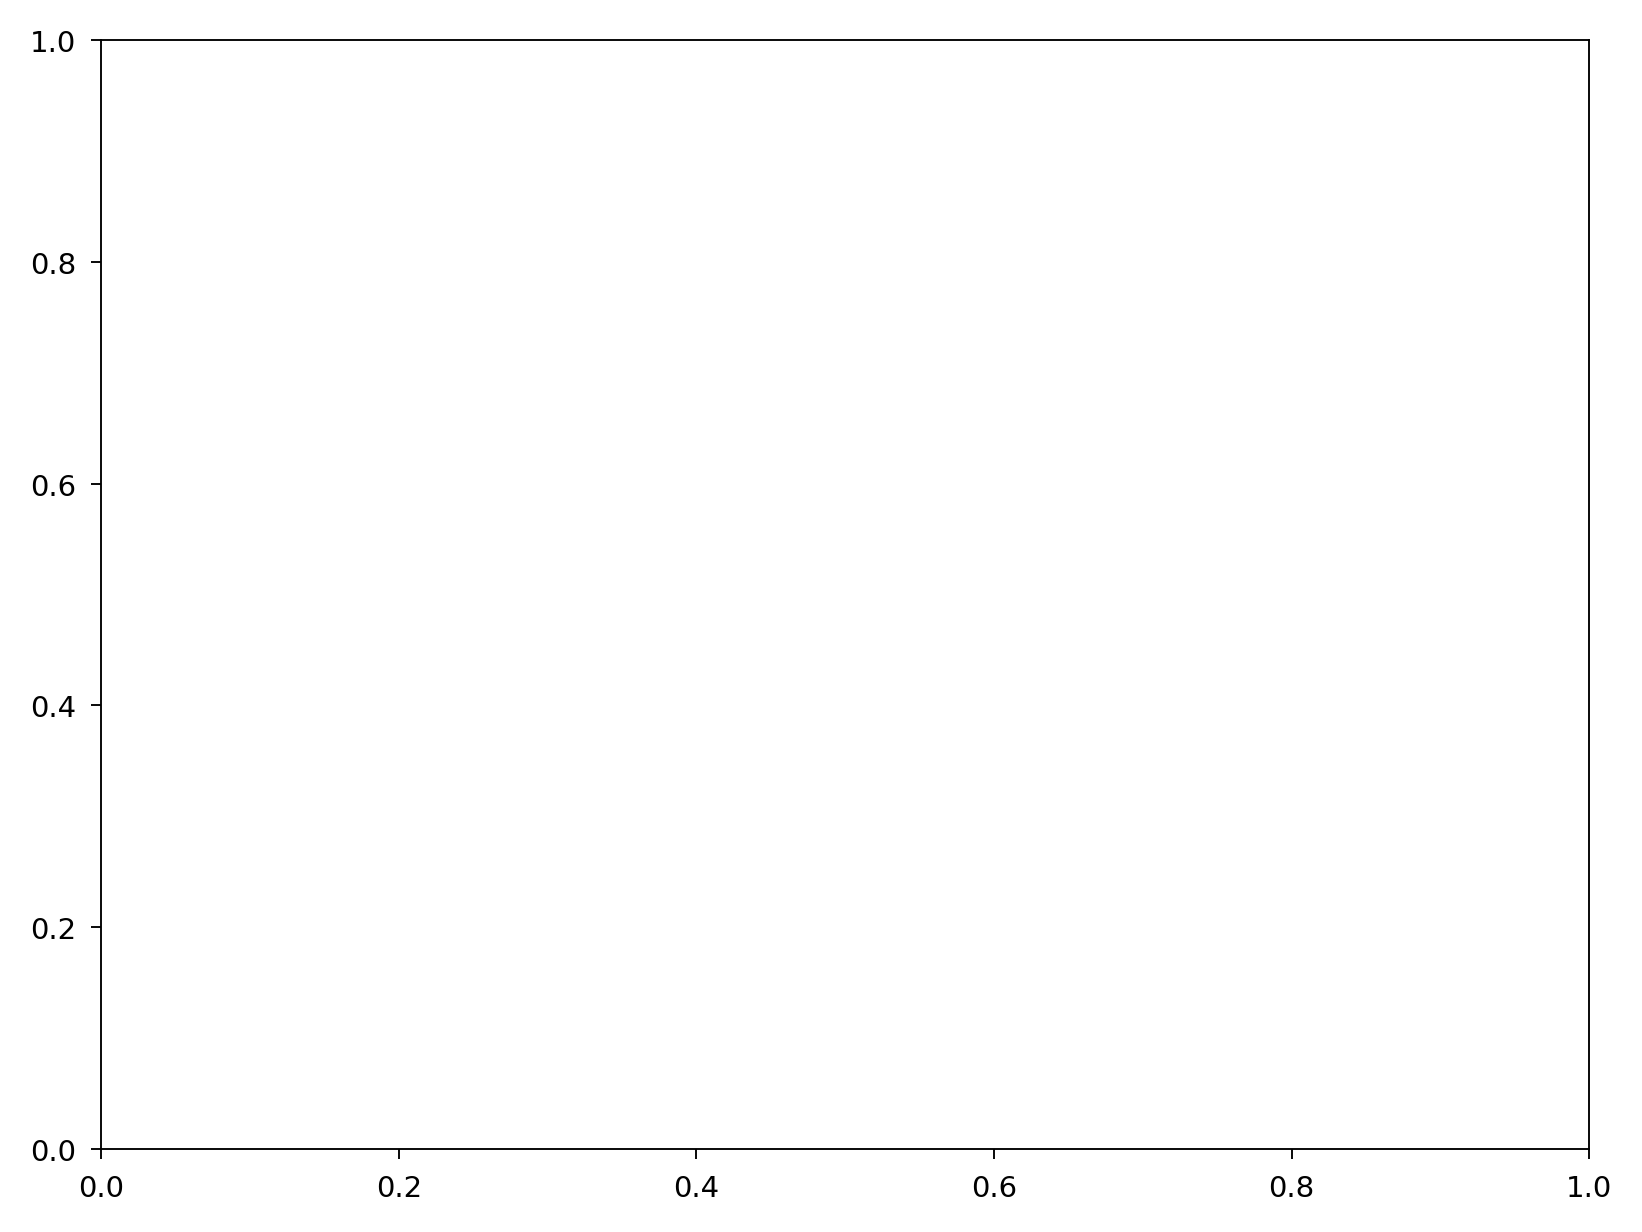

In [7]:
fig, ax = plt.subplots(1,1)
cmap = plt.get_cmap('YlGnBu')
p = seaborn.lineplot(df_filtered, ax=ax, x='max_rxns', y='Expected Reward', hue='starting_material_budget', legend='full')
ax.set_xlabel('Maximum Number of Reactions')
ax.set_ylabel('Expected Reward')
for line, label in zip(ax.get_lines(), ax.get_legend_handles_labels()[1]): 
    xydata = line.get_xydata()
    if xydata.shape[0] > 5:
        y = xydata[-2,1] 
        ax.text(135, y+0.15, label, color=line.get_color(), fontsize=8)
ax.legend(bbox_to_anchor=(1.1, 1.05), title='Budget (SM)')
# ax.set_ylim([0, 12])
plot_utils.set_size(w=3, h=2.5, ax=ax)



# Comparing expected reward formulation with scalarized formulation and baselines

### color settings

In [152]:
c_nonlinear = '#44AA99'
c_linear = '#CC6677'

### Get SPARROW curves

In [99]:
data = []
for subf in Path(f'../results/{case}_rxnconstr_nonlinear').glob('*'):
    dat = get_info(subf)
    if dat is not None: 
        data.append(dat)

df_rxns = pd.DataFrame(data)

data = []
for subf in Path(f'../results/{case}_budgetconstr_nonlinear').glob('*'):
    dat = get_info(subf)
    if dat is not None: 
        data.append(dat)

df_budget = pd.DataFrame(data)

### Get baseline data

In [100]:
if case=='garib': 
    case_b = 'garibsingh'
else: 
    case_b = case 
    
baselines = pd.read_csv(f'../examples/{case_b}/baselines/baseline_curves.csv')
baselines = baselines.loc[baselines.N>0]
baselines = baselines.rename(columns={
    'Cost': 'Starting Material Cost', 
    'Reward': 'Cumulative Reward', 
    'N_rxns': 'Number of Reactions',
    'Average reaction score': 'Average Reaction Score'})

### Get SPARROW linear formulation data 

In [101]:
data = []
for subf in Path(f'../results/{case}_rxnconstr_linear').glob('*'):
    dat = get_info(subf)
    if dat is not None: 
        data.append(dat)

linear_rxns = pd.DataFrame(data)

data = []
for subf in Path(f'../results/{case}_budgetconstr_linear').glob('*'):
    dat = get_info(subf)
    if dat is not None: 
        data.append(dat)

linear_budget = pd.DataFrame(data)



### Plots

In [102]:
for df in [df_budget, df_rxns, linear_budget, linear_rxns]: 
    df = df.rename(columns={
            'Number reaction steps (actual)': 'Number of Reactions',
            'Starting Material Cost (Actual)': 'Starting Material Cost',
        }, inplace=True)

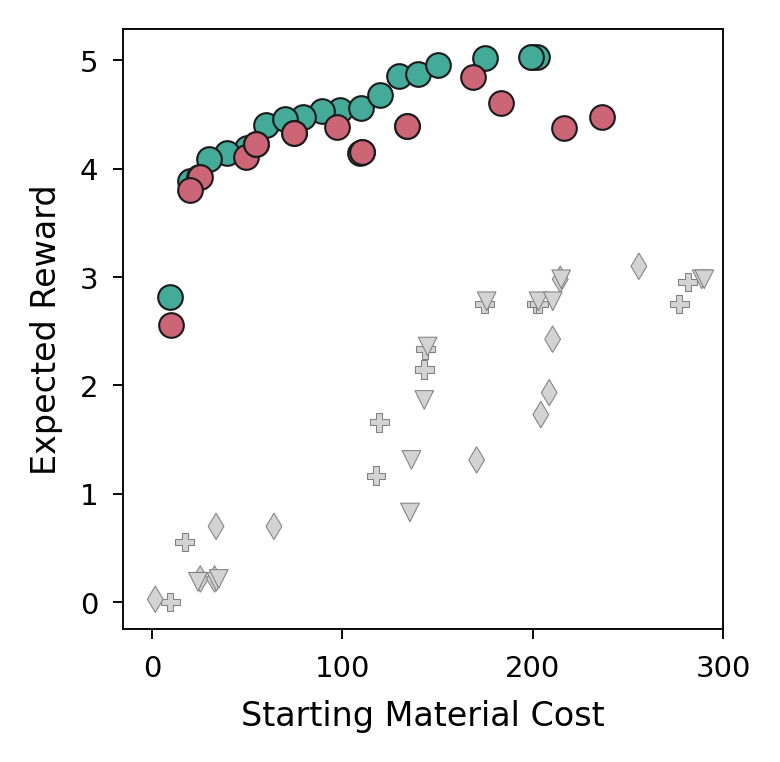

In [103]:
fig, ax = plt.subplots(1,1)

markers = {"Reward Only": "P", "SA Score Only": "d", "Combined Score": "v"} 
seaborn.scatterplot(data=baselines, ax=ax, x='Starting Material Cost', y='Expected Reward', style='strategy', color="lightgray", s=20, edgecolor='gray', linewidth=0.25, markers=markers,legend=False)
seaborn.scatterplot(data=df_budget, c=c_nonlinear, ax=ax, x='Starting Material Cost', y='Expected Reward', s=35, edgecolor='k', linewidth=0.5, legend=False)
seaborn.scatterplot(data=linear_budget, c=c_linear, ax=ax, x='Starting Material Cost', y='Expected Reward', s=35, edgecolor='k', linewidth=0.5, legend=False)
ax.set_xlim([-15, 300])
plot_utils.set_size(w=2, h=2, ax=ax)

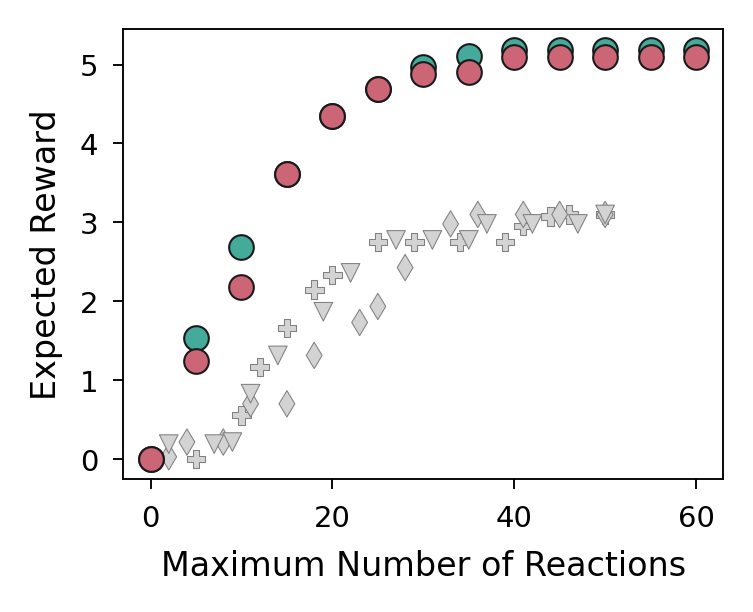

In [104]:
if case=='garib': 
    df_rxns = df_rxns.loc[df_rxns['max_rxns']<=60]
    linear_rxns = linear_rxns.loc[linear_rxns['max_rxns']<=60]

fig, ax = plt.subplots(1,1)

markers = {"Reward Only": "P", "SA Score Only": "d", "Combined Score": "v"} 
seaborn.scatterplot(data=baselines, ax=ax, x='Number of Reactions', y='Expected Reward', style='strategy', color="lightgray", s=20, edgecolor='gray', linewidth=0.25, legend=False, markers=markers)
seaborn.scatterplot(data=df_rxns, c=c_nonlinear, ax=ax, x='max_rxns', y='Expected Reward', s=35, edgecolor='k', linewidth=0.5, legend=False)
seaborn.scatterplot(data=linear_rxns, c=c_linear, ax=ax, x='max_rxns', y='Expected Reward', s=35, edgecolor='k', linewidth=0.5, legend=False)
# seaborn.move_legend(
#     ax, "lower center",
#     bbox_to_anchor=(.5, 1), ncol=2, title=None, frameon=False,
# )
ax.set_xlabel('Maximum Number of Reactions')
plot_utils.set_size(w=2, h=1.5, ax=ax)


### Create legend 

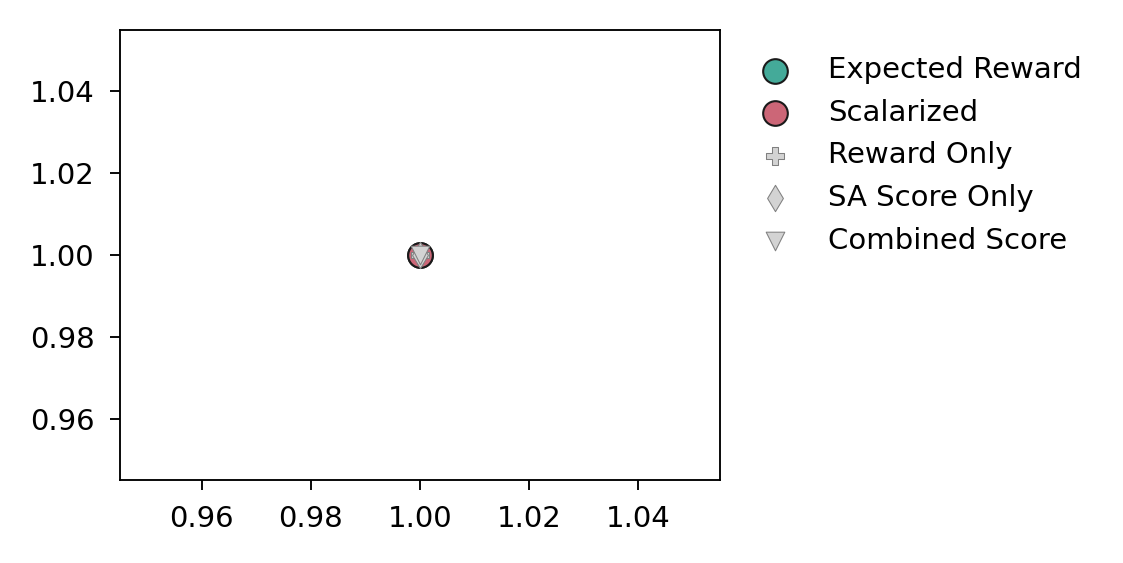

In [116]:
fig, ax = plt.subplots(1,1)
markers = {"Reward Only": "P", "SA Score Only": "d", "Combined Score": "v"} 

ax.scatter([1], [1], s=35, edgecolor='k', linewidth=0.5, c=c_nonlinear, label='Expected Reward')
ax.scatter([1], [1], s=35, edgecolor='k', linewidth=0.5, c=c_linear, label='Scalarized')
for label, m in markers.items(): 
    ax.scatter([1], [1], color="lightgray", s=20, edgecolor='gray', linewidth=0.25, label=label, marker=m)

ax.legend(ncol=1, bbox_to_anchor=(1, 1))
plot_utils.set_size(w=2, h=1.5, ax=ax)



# Diversity Figures 

## TSNEs 

### Functions

In [4]:
def get_selections(folder: Path): 
    with open(folder / 'solution' / 'solution_list_format.json', 'r') as f: 
        sol = json.load(f)

    selections = [e['smiles'] for e in sol["Targets"]]
    return selections

def fp_list_from_smiles_list(smiles_list,n_bits=2048):
    """ Ref: Pat Walters' Practical Cheminformatics blog (https://github.com/PatWalters/workshop/blob/master/predictive_models/2_visualizing_chemical_space.ipynb) """
    fp_list = []
    for smiles in tqdm(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        fp_list.append(fp_as_array(mol,n_bits))
    return fp_list

def fp_as_array(mol,n_bits=2048):
    """ Ref: Pat Walters' Practical Cheminformatics blog (https://github.com/PatWalters/workshop/blob/master/predictive_models/2_visualizing_chemical_space.ipynb) """
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
    arr = np.zeros((1,), int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

### Settings

In [419]:
no_div_res = Path('/home/jfromer/collabs/ml-for-tb/acs_fall2024_diversity/results2_no_diversity')
div_res = Path('/home/jfromer/collabs/ml-for-tb/acs_fall2024_diversity/results2_diversity')
targets = pd.read_csv('/home/jfromer/collabs/ml-for-tb/may_2024/data/targets_0.1.csv')['SMILES']

smis_no_div = get_selections(no_div_res)
smis_div = get_selections(div_res)



In [414]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = TSNE(n_components=2, random_state=1, perplexity=50)

fp_candidates = fp_list_from_smiles_list(targets)
crds_candidates = {smi: crds for smi, crds in 
                   zip(targets, pca.fit_transform(fp_candidates))}


100%|██████████| 5686/5686 [00:01<00:00, 3623.69it/s]
/mnt/home/jfromer/miniforge3/envs/sparrow/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/mnt/home/jfromer/miniforge3/envs/sparrow/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


### Plotting

In [420]:
crds_div = [crds_candidates[smi] for smi in smis_div]
crds_no_div = [crds_candidates[smi] for smi in smis_no_div]

In [421]:
proj = pd.DataFrame([*crds_candidates.values(), *crds_no_div, *crds_div], columns=['PC 1', 'PC 2'])
classes = [*['All candidates']*len(targets), *['No diversity term']*len(smis_no_div) , *['With diversity term']*len(smis_div)]
proj['Class'] = classes
proj.to_csv('projections.csv')

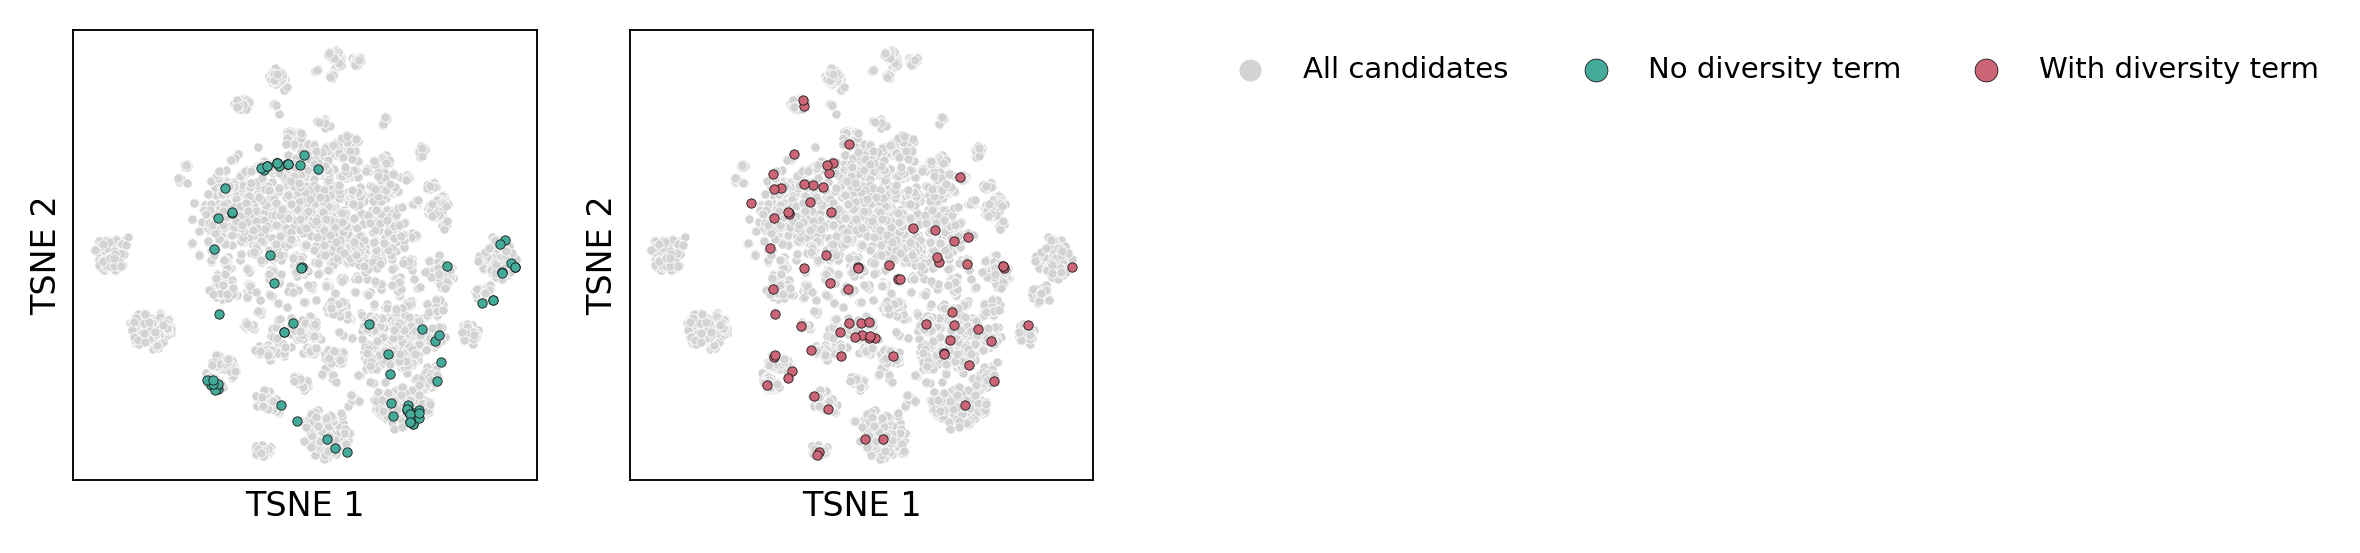

In [466]:
proj_no_div = proj.loc[proj['Class']=='No diversity term']
proj_div = proj.loc[proj['Class']=='With diversity term']
proj_cand = proj.loc[proj['Class']=='All candidates']

fig, ax = plt.subplots(1,2)


seaborn.scatterplot(data=proj_cand,x="PC 1",y="PC 2", s=5,
                         c='lightgray', ax=ax[0], legend=False, label='All candidates')
seaborn.scatterplot(data=proj_no_div,x="PC 1",y="PC 2", s=5, edgecolor='k', linewidth=0.2,
                         c=c_nonlinear, ax=ax[0], legend=False, label='No diversity term')

seaborn.scatterplot(data=proj_cand,x="PC 1",y="PC 2", s=5,
                         c='lightgray', ax=ax[1], legend=False)
seaborn.scatterplot(data=proj_div,x="PC 1",y="PC 2", s=5, edgecolor='k', linewidth=0.2,
                         c=c_linear, ax=ax[1], legend=False, label='With diversity term')

for a in ax: 
    a.get_yaxis().set_ticks([])
    a.get_xaxis().set_ticks([])
    a.set_xlabel(xlabel='TSNE 1',labelpad=0)
    a.set_ylabel(ylabel='TSNE 2',labelpad=0)

lgd1 = ax[0].legend(ncol=2, bbox_to_anchor=(4, 1))
lgd2 = ax[1].legend(ncol=1, bbox_to_anchor=(3.7, 1))
for lgd in [lgd1, lgd2]: 
    for h in lgd.legendHandles: 
        h._sizes = [30]

plot_utils.set_size(w=3.4, h=1.5, ax=a)

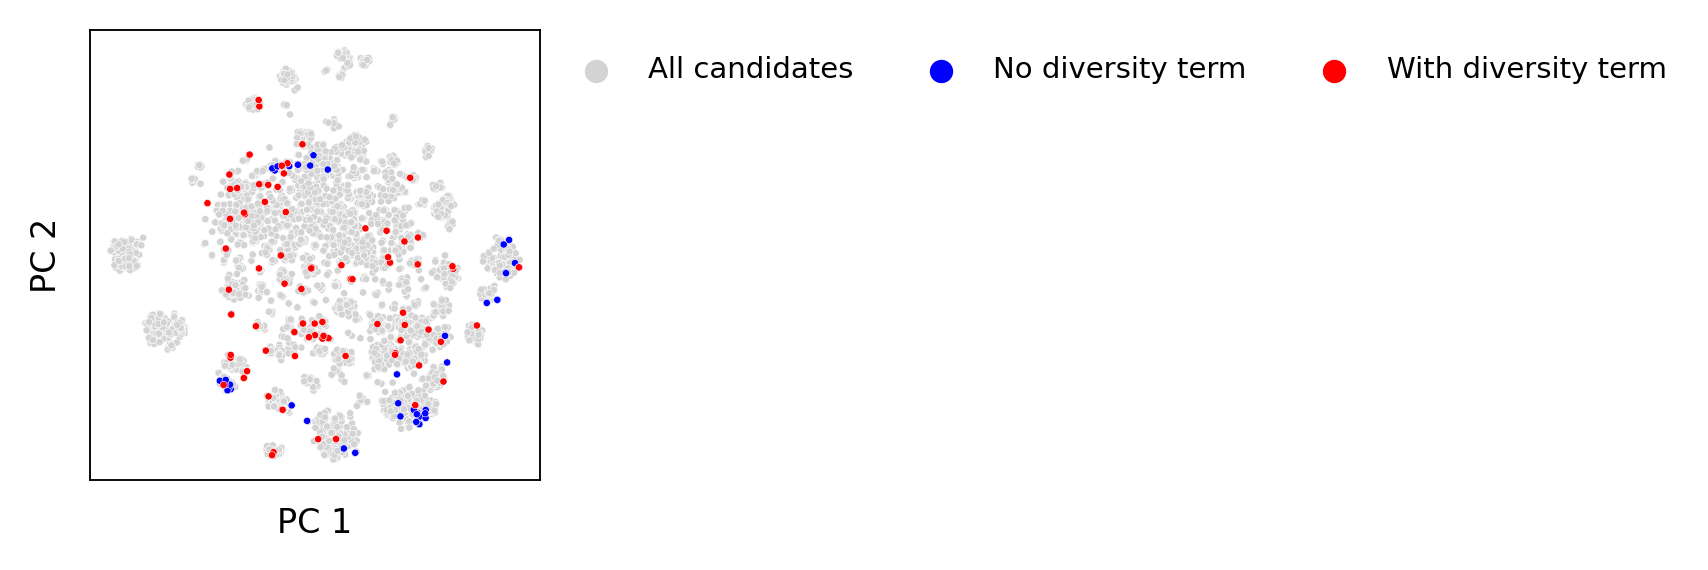

In [470]:
fig, ax = plt.subplots(1,1)
seaborn.scatterplot(data=proj,x="PC 1",y="PC 2",hue="Class", s=3,
                         palette={'All candidates':'lightgray', 'With diversity term':'red','No diversity term':'blue'}, ax=ax)
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks([])
ax.legend(ncol=3, bbox_to_anchor=(1, 1))

plot_utils.set_size(w=1.5, h=1.5, ax=ax)

## Vary weighting factor 

In [482]:
data = []
for folder in Path('/home/jfromer/collabs/ml-for-tb/acs_fall2024_diversity/results_vary_diversity').glob('*'): 
    with open(folder/'solution'/'solution_list_format.json', 'r') as f: 
        sol = json.load(f)
    clusters = set([c['clusters'][0] for c in sol['Targets']])
    params = read_ini(folder/'params.ini')
    params['N_clusters'] = len(clusters)
    data.append(params)

df_diversity = pd.DataFrame(data)

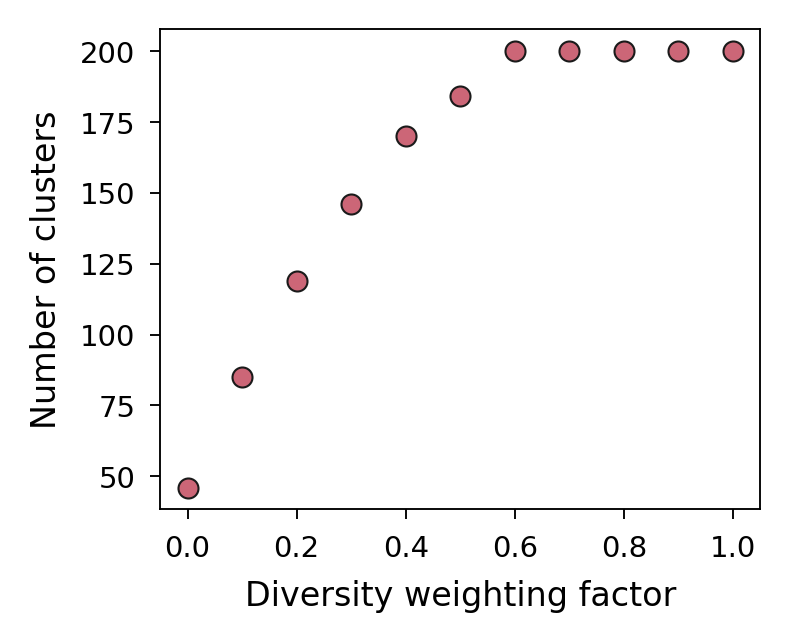

In [493]:
fig, ax = plt.subplots(1,1)
seaborn.scatterplot(data=df_diversity, x='diversity_weight', y='N_clusters', c=c_linear, ax=ax, linewidth=0.5, edgecolor='k')
ax.set_xlabel('Diversity weighting factor')
ax.set_ylabel('Number of clusters')
plot_utils.set_size(2, 1.6, ax=ax)